# Gömülü Yöntem (Embedded Method) - Random Forest Feature Importance

Bu notebook, **Random Forest (Rastgele Orman)** algoritmasının özellik önem skorlarını kullanarak özellik seçimi yapar.

## Yöntem Açıklaması
- Random Forest modeli eğitilir
- Her özelliğin önem skoru (feature_importances_) hesaplanır
- En yüksek önem skoruna sahip 15 özellik seçilir

**Referans:** https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [1]:
# Gerekli kütüphaneleri import et
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

# Helper modüllerini import et
from dataset_helper import (
    load_processed_dataset,
    split_features_target,
    save_selected_dataset,
    get_feature_ranking,
    get_top_features
)
from file_helper import write_report
from report_helper import generate_analysis_report

## 1. Veri Kümesini Yükle

In [2]:
# İşlenmiş veri kümesini yükle
df = load_processed_dataset()

# Özellik ve hedef değişken olarak ayır
X, y = split_features_target(df, target_column='is_popular')

print(f"\nÖzellik isimleri:")
print(X.columns.tolist())

Veri kümesi yüklendi: c:\Users\kayra\OneDrive\Üniversite\Dersler\Doktora\Dönem 1\Makine Öğrenmesi\ödev2\kodlar\feature_selection\..\dataset_files\processed_dataset.csv
Boyut: (39644, 59)
Özellik sayısı: 58
Örnek sayısı: 39644
Sınıf dağılımı: 0 -> 18490, 1 -> 21154

Özellik isimleri:
['n_tokens_title', 'n_tokens_content', 'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens', 'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos', 'average_token_length', 'num_keywords', 'data_channel_is_lifestyle', 'data_channel_is_entertainment', 'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech', 'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min', 'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg', 'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday', 'weekday_is_saturday', 'week

## 2. Random Forest Modeli Eğit

In [3]:
# Random Forest modeli oluştur
# n_estimators: ağaç sayısı, daha fazla ağaç daha stabil önem skorları sağlar
print("Random Forest modeli eğitiliyor...")
print("Bu işlem birkaç dakika sürebilir...\n")

rf_model = RandomForestClassifier(
    n_estimators=100,      # 100 karar ağacı
    max_depth=None,        # Sınırsız derinlik
    min_samples_split=2,   # Bölme için minimum örnek
    min_samples_leaf=1,    # Yaprak düğüm için minimum örnek
    random_state=42,       # Tekrarlanabilirlik için
    n_jobs=-1,             # Tüm CPU çekirdeklerini kullan
    verbose=1
)

# Modeli eğit
rf_model.fit(X, y)

print("\nRandom Forest eğitimi tamamlandı!")

Random Forest modeli eğitiliyor...
Bu işlem birkaç dakika sürebilir...



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.7s



Random Forest eğitimi tamamlandı!


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished


## 3. Özellik Önem Skorlarını Al

In [4]:
# Özellik önem skorlarını al
feature_names = X.columns.tolist()
importance_scores = rf_model.feature_importances_

print(f"Toplam özellik sayısı: {len(importance_scores)}")
print(f"Önem skoru aralığı: [{importance_scores.min():.6f}, {importance_scores.max():.6f}]")
print(f"Toplam önem skoru: {importance_scores.sum():.4f}")

Toplam özellik sayısı: 58
Önem skoru aralığı: [0.000115, 0.044761]
Toplam önem skoru: 1.0000


## 4. Özellikleri Sırala

In [5]:
# Özellik sıralamasını oluştur
ranking_df = get_feature_ranking(feature_names, importance_scores, top_n=15)

# Tüm özelliklerin sıralamasını göster
print("\n=== TÜM ÖZELLİKLERİN ÖNEM SIRALAMASI ===")
print(ranking_df.to_string(index=False))


=== TÜM ÖZELLİKLERİN ÖNEM SIRALAMASI ===
 Sıra                       Özellik  Ham Skor  Mutlak Skor  Normalize Skor
    1                    kw_avg_avg  0.044761     0.044761        1.000000
    2                    kw_max_avg  0.040521     0.040521        0.905048
    3                        LDA_02  0.032028     0.032028        0.714801
    4     self_reference_min_shares  0.031323     0.031323        0.699014
    5                    kw_avg_min  0.029480     0.029480        0.657725
    6                    kw_avg_max  0.029337     0.029337        0.654539
    7                        LDA_01  0.029188     0.029188        0.651190
    8    self_reference_avg_sharess  0.028946     0.028946        0.645762
    9                        LDA_04  0.028847     0.028847        0.643556
   10                        LDA_00  0.028460     0.028460        0.634878
   11               n_unique_tokens  0.027256     0.027256        0.607910
   12           global_subjectivity  0.027157     0.027157

## 5. En İyi 15 Özelliği Seç

In [6]:
# En iyi 15 özelliği seç
TOP_N = 15
selected_features = get_top_features(ranking_df, TOP_N)

print(f"\n=== SEÇİLEN EN İYİ {TOP_N} ÖZELLİK ===")
for i, feature in enumerate(selected_features, 1):
    score = ranking_df[ranking_df['Özellik'] == feature]['Ham Skor'].values[0]
    norm_score = ranking_df[ranking_df['Özellik'] == feature]['Normalize Skor'].values[0]
    print(f"{i:2d}. {feature:35s} - Önem: {score:.6f}, Normalize: {norm_score:.4f}")


=== SEÇİLEN EN İYİ 15 ÖZELLİK ===
 1. kw_avg_avg                          - Önem: 0.044761, Normalize: 1.0000
 2. kw_max_avg                          - Önem: 0.040521, Normalize: 0.9050
 3. LDA_02                              - Önem: 0.032028, Normalize: 0.7148
 4. self_reference_min_shares           - Önem: 0.031323, Normalize: 0.6990
 5. kw_avg_min                          - Önem: 0.029480, Normalize: 0.6577
 6. kw_avg_max                          - Önem: 0.029337, Normalize: 0.6545
 7. LDA_01                              - Önem: 0.029188, Normalize: 0.6512
 8. self_reference_avg_sharess          - Önem: 0.028946, Normalize: 0.6458
 9. LDA_04                              - Önem: 0.028847, Normalize: 0.6436
10. LDA_00                              - Önem: 0.028460, Normalize: 0.6349
11. n_unique_tokens                     - Önem: 0.027256, Normalize: 0.6079
12. global_subjectivity                 - Önem: 0.027157, Normalize: 0.6057
13. n_non_stop_unique_tokens            - Önem: 0.026

In [7]:
# Seçilen özelliklerin toplam önem yüzdesi
selected_importance = sum(ranking_df[ranking_df['Özellik'].isin(selected_features)]['Ham Skor'])
total_importance = sum(importance_scores)
importance_percentage = (selected_importance / total_importance) * 100

print(f"\nSeçilen {TOP_N} özelliğin toplam önemi: {selected_importance:.4f}")
print(f"Toplam önemin yüzdesi: %{importance_percentage:.2f}")


Seçilen 15 özelliğin toplam önemi: 0.4572
Toplam önemin yüzdesi: %45.72


## 6. Görselleştirme

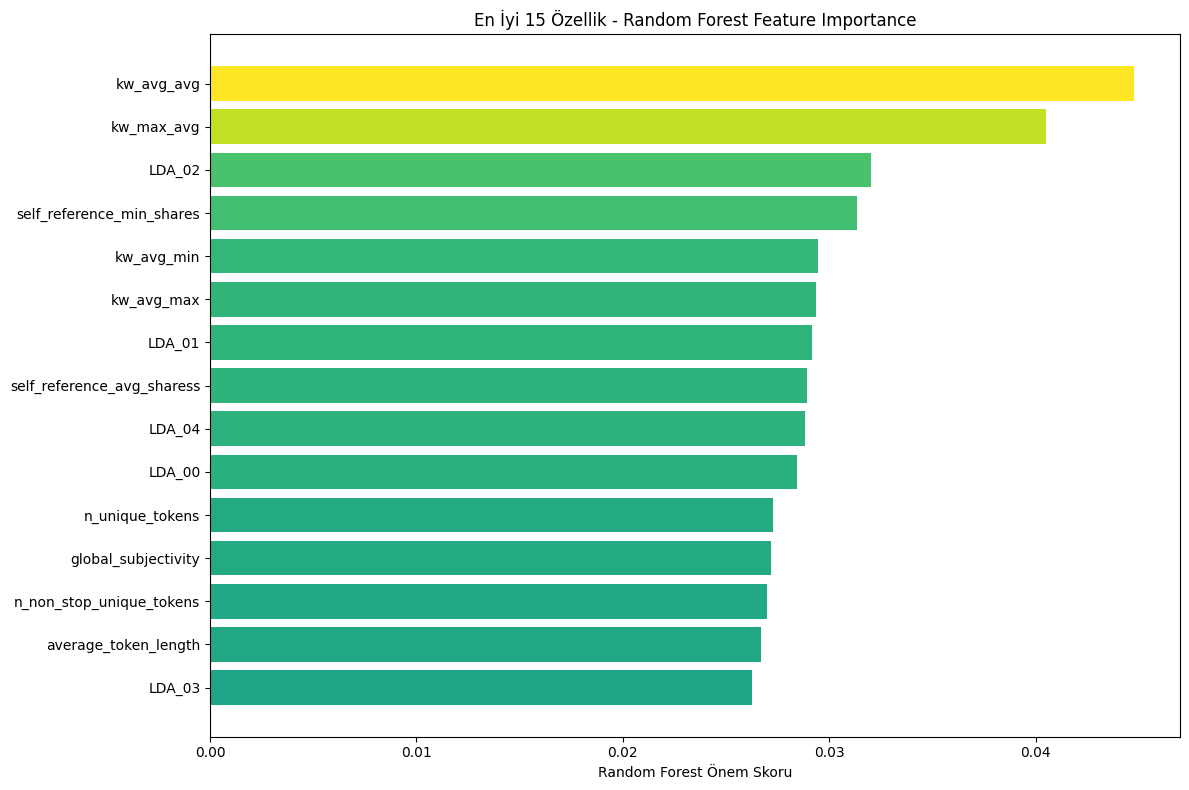

Grafik kaydedildi: embedded_method_importance.png


In [8]:
import matplotlib.pyplot as plt

# Seçilen özellikler için bar plot
top_15_df = ranking_df.head(TOP_N).copy()

plt.figure(figsize=(12, 8))
colors = plt.cm.viridis(top_15_df['Normalize Skor'])
plt.barh(range(len(top_15_df)), top_15_df['Ham Skor'], color=colors)
plt.yticks(range(len(top_15_df)), top_15_df['Özellik'])
plt.xlabel('Random Forest Önem Skoru')
plt.title('En İyi 15 Özellik - Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('photos/embedded_method_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("Grafik kaydedildi: embedded_method_importance.png")

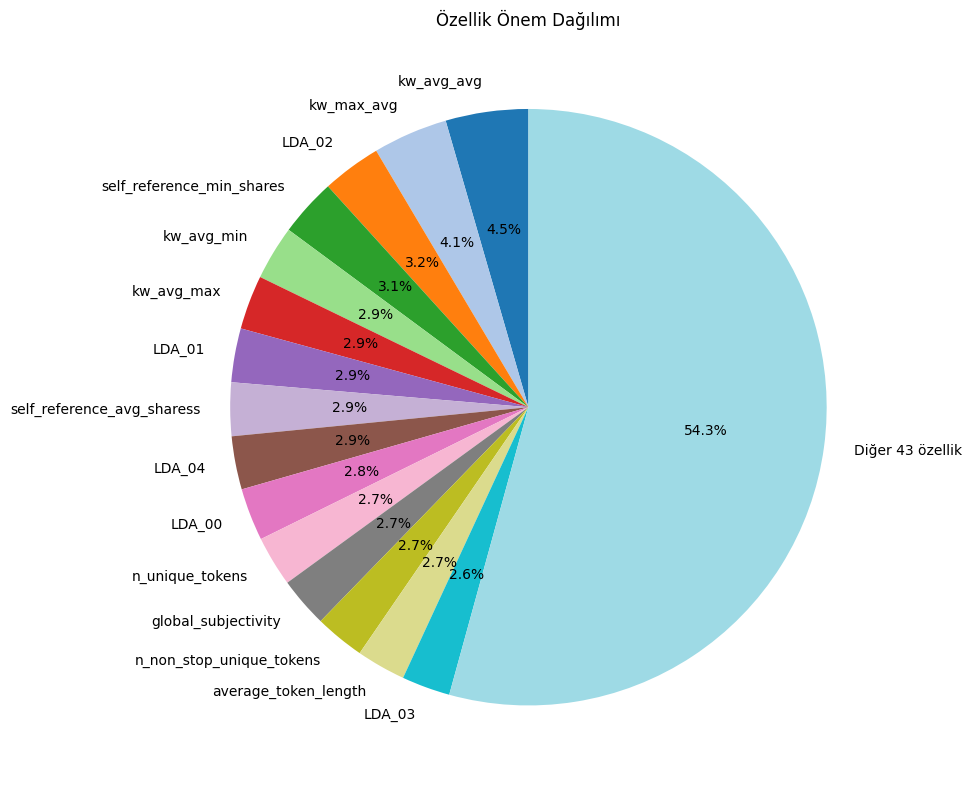

Pasta grafiği kaydedildi: embedded_method_pie.png


In [ ]:
# Pasta grafiği - Top 15 vs Diğerleri
plt.figure(figsize=(10, 8))

# Her özellik için ayrı dilim
top_15_importance = ranking_df.head(TOP_N)['Ham Skor'].values
top_15_labels = ranking_df.head(TOP_N)['Özellik'].values
other_importance = ranking_df.tail(len(ranking_df) - TOP_N)['Ham Skor'].sum()

sizes = list(top_15_importance) + [other_importance]
labels = list(top_15_labels) + [f'Diğer {len(ranking_df) - TOP_N} özellik']

# Renk paleti
colors = plt.cm.tab20(np.linspace(0, 1, len(sizes)))

plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('Özellik Önem Dağılımı')
plt.tight_layout()
plt.savefig('photos/embedded_method_pie.png', dpi=150, bbox_inches='tight')
plt.show()

print("Pasta grafiği kaydedildi: embedded_method_pie.png")

## 7. Analiz Raporu Oluştur

In [10]:
# Rapor için yöntem açıklaması
method_description = f"""
Gömülü yöntem olarak **Random Forest (Rastgele Orman)** kullanılmıştır. 
Bu yöntem, ağaç tabanlı topluluk öğrenme algoritmasının özellik önem skorlarını kullanır.

### Yöntem Detayları:
- Random Forest, birden fazla karar ağacı eğitir
- Her özelliğin önemi, ağaçlardaki bölünmelere katkısına göre hesaplanır
- Gini impurity veya entropi azalması kullanılır
- Önem skorları 0-1 arasında normalize edilmiştir

### Model Parametreleri:
- **n_estimators:** 100 ağaç
- **max_depth:** Sınırsız
- **min_samples_split:** 2
- **min_samples_leaf:** 1

### Avantajları:
- Doğrusal olmayan ilişkileri yakalar
- Özellikler arası etkileşimleri dikkate alır
- Overfitting'e karşı dirençli
- Hızlı ve verimli

### Dezavantajları:
- Yorumlanabilirlik nispeten düşük
- Yüksek kardinaliteli kategorik değişkenler için yanlılık olabilir

### İstatistikler:
- İlk {TOP_N} özellik toplam önemin **%{importance_percentage:.2f}**'sini oluşturmaktadır.
"""

# Dataset bilgisi
dataset_info = {
    "name": "processed_dataset.csv",
    "shape": f"{df.shape}",
    "source": "UCI Online News Popularity"
}

# Ek notlar
additional_notes = """
Random Forest özellik önemi, her özelliğin karar ağaçlarındaki bölünmelere ne kadar 
katkı sağladığını gösterir. Bu yöntem, özellikle doğrusal olmayan ilişkileri ve 
özellikler arası etkileşimleri yakalamada etkilidir.

**Not:** Random Forest, ensemble (topluluk) öğrenme yöntemi olduğu için, özellik 
önemleri birden fazla modelin ortalamasıdır ve bu nedenle daha güvenilirdir.
"""

# Rapor oluştur
report_content = generate_analysis_report(
    method_name="Gömülü Yöntem - Random Forest Feature Importance",
    method_description=method_description,
    ranking_df=ranking_df,
    top_n=TOP_N,
    dataset_info=dataset_info,
    additional_notes=additional_notes
)

# Rapor kaydet
write_report(report_content, "embedded_analysis_report.md")

print("\nRapor başarıyla oluşturuldu!")

Rapor kaydedildi: c:\Users\kayra\OneDrive\Üniversite\Dersler\Doktora\Dönem 1\Makine Öğrenmesi\ödev2\kodlar\feature_selection\embedded_analysis_report.md

Rapor başarıyla oluşturuldu!


## 8. Seçilen Özelliklerle Veri Kümesi Oluştur

In [11]:
# Seçilen özelliklerle yeni veri kümesi oluştur ve kaydet
output_file = "embedded_method_selected_dataset.csv"

save_selected_dataset(
    df=df,
    selected_features=selected_features,
    target_column='is_popular',
    filename=output_file
)

print(f"\n✅ Gömülü yöntemi tamamlandı!")
print(f"   - {TOP_N} özellik seçildi")
print(f"   - Veri kümesi: {output_file}")
print(f"   - Rapor: embedded_analysis_report.md")


Seçilen özelliklerle veri kümesi kaydedildi: c:\Users\kayra\OneDrive\Üniversite\Dersler\Doktora\Dönem 1\Makine Öğrenmesi\ödev2\kodlar\feature_selection\..\dataset_files\embedded_method_selected_dataset.csv
Boyut: (39644, 16)
Sütunlar: ['kw_avg_avg', 'kw_max_avg', 'LDA_02', 'self_reference_min_shares', 'kw_avg_min', 'kw_avg_max', 'LDA_01', 'self_reference_avg_sharess', 'LDA_04', 'LDA_00', 'n_unique_tokens', 'global_subjectivity', 'n_non_stop_unique_tokens', 'average_token_length', 'LDA_03', 'is_popular']

✅ Gömülü yöntemi tamamlandı!
   - 15 özellik seçildi
   - Veri kümesi: embedded_method_selected_dataset.csv
   - Rapor: embedded_analysis_report.md


## 9. Özet

In [12]:
print("="*60)
print("GÖMÜLÜ YÖNTEMİ - ÖZET")
print("="*60)
print(f"Kullanılan Yöntem: Random Forest Feature Importance")
print(f"Ağaç Sayısı: 100")
print(f"Toplam Özellik Sayısı: {len(feature_names)}")
print(f"Seçilen Özellik Sayısı: {TOP_N}")
print(f"Seçilen Özelliklerin Önem Yüzdesi: %{importance_percentage:.2f}")
print(f"\nSeçilen Özellikler:")
for i, feat in enumerate(selected_features, 1):
    print(f"  {i}. {feat}")
print("="*60)

GÖMÜLÜ YÖNTEMİ - ÖZET
Kullanılan Yöntem: Random Forest Feature Importance
Ağaç Sayısı: 100
Toplam Özellik Sayısı: 58
Seçilen Özellik Sayısı: 15
Seçilen Özelliklerin Önem Yüzdesi: %45.72

Seçilen Özellikler:
  1. kw_avg_avg
  2. kw_max_avg
  3. LDA_02
  4. self_reference_min_shares
  5. kw_avg_min
  6. kw_avg_max
  7. LDA_01
  8. self_reference_avg_sharess
  9. LDA_04
  10. LDA_00
  11. n_unique_tokens
  12. global_subjectivity
  13. n_non_stop_unique_tokens
  14. average_token_length
  15. LDA_03
